# **Crowdsourced Label Aggregation Workflow**

This notebook demonstrates the workflow for analyzing and aggregating crowdsourced relevance judgments using various methods, from majority voting to machine learning models. Each section corresponds to a specific experiment, showcasing its implementation, accuracy, and results.

---

In [17]:
## Setup and Data Loading

# Import necessary libraries
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight


In [18]:
# Load the dataset
file_path = "trec-rf10-data.txt"
data = pd.read_csv(file_path, sep="\t", header=0)

In [19]:
# Filter tasks with gold labels
gold_data = data[data['gold'] != -1]

## Experiment 1: Majority Voting

**Objective**: This experiment uses majority voting as the aggregation method, where the most frequent label assigned by workers for a given task is selected as the consensus label. 

**Key Steps**:
1. Group labels by task (`topicID`, `docID`).
2. Count the frequency of each label.
3. Select the label with the highest frequency as the final label. Ties are resolved randomly.

**Evaluation**: Accuracy is computed by comparing the majority-voted labels to the gold labels. A confusion matrix is generated to show the distribution of predictions.

**Results**: The accuracy of majority voting will serve as the baseline for comparison with more advanced methods in subsequent experiments.


Accuracy of Majority Voting: 53.95%


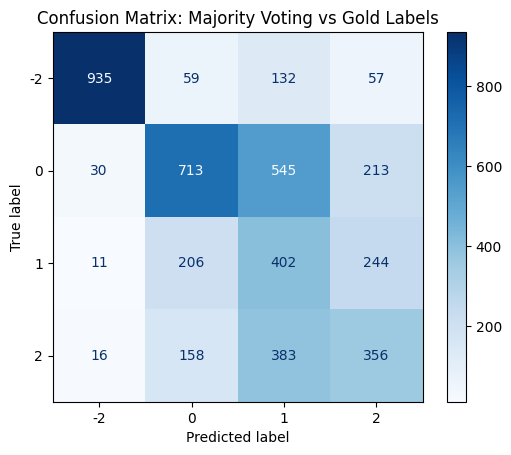

In [54]:
# Set a random seed for reproducibility
np.random.seed(42)

# Function to apply majority voting for each group
def majority_vote(labels):
    label_counts = Counter(labels)
    # Handle ties by selecting a random label among the most frequent
    max_count = max(label_counts.values())
    top_labels = [label for label, count in label_counts.items() if count == max_count]
    return np.random.choice(top_labels)

# Apply majority vote to each task
majority_labels = grouped['label'].apply(majority_vote).reset_index()
majority_labels.columns = ['topicID', 'docID', 'majority_label']

# Merge majority vote results with the gold labels for comparison
gold_labels = gold_data[['topicID', 'docID', 'gold']].drop_duplicates()
results = pd.merge(majority_labels, gold_labels, on=['topicID', 'docID'])

# Calculate accuracy: Compare majority vote labels to gold labels
accuracy = (results['majority_label'] == results['gold']).mean()
print(f"Accuracy of Majority Voting: {accuracy:.2%}")

# Optional: Display a confusion matrix for more detailed analysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(results['gold'], results['majority_label'], labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: Majority Voting vs Gold Labels")
disp.figure_.savefig("majority_vote_confusion_matrix.png")


## Experiment 2: Weighted Voting

**Objective**: This experiment introduces weighted voting, where the contribution of each worker's label is weighted by their individual accuracy on gold-labeled tasks.

**Key Steps**:
1. Compute worker accuracy by comparing their labels to gold labels.
2. Assign higher weights to workers with higher accuracy.
3. Aggregate labels using a weighted majority voting mechanism, where the final label is the one with the highest weighted score.

**Evaluation**: The method is evaluated using accuracy and a confusion matrix, as in Experiment 1.

**Expected Outcome**: Weighted voting should improve accuracy over majority voting by accounting for worker reliability.


Accuracy of Weighted Voting: 62.13%


Text(0.5, 1.0, 'Confusion Matrix: Weighted Voting vs Gold Labels')

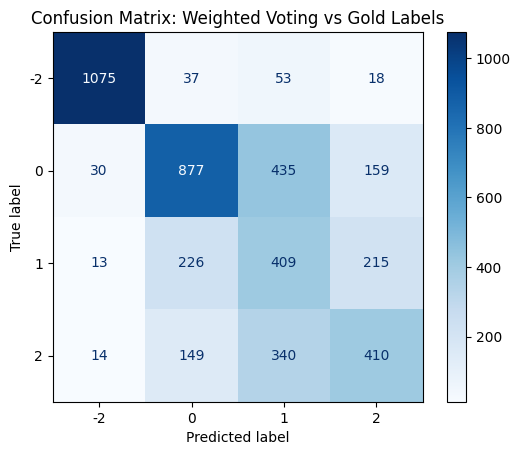

In [28]:
# Compute worker accuracy
def compute_worker_accuracy(gold_data):
    worker_accuracy = {}
    grouped = gold_data.groupby('workerID')
    for worker, group in grouped:
        correct = (group['label'] == group['gold']).sum()
        total = len(group)
        accuracy = correct / total if total > 0 else 0
        worker_accuracy[worker] = accuracy
    return worker_accuracy

worker_accuracy = compute_worker_accuracy(gold_data)

# Weighted majority vote function
def weighted_majority_vote(group, worker_accuracy):
    weighted_votes = defaultdict(float)
    for _, row in group.iterrows():
        weight = worker_accuracy.get(row['workerID'], 0)
        weighted_votes[row['label']] += weight
    max_weight = max(weighted_votes.values())
    top_labels = [label for label, weight in weighted_votes.items() if weight == max_weight]
    return np.random.choice(top_labels)

# Apply weighted voting
grouped_tasks = gold_data.groupby(['topicID', 'docID'])
weighted_results = []

for (topicID, docID), group in grouped_tasks:
    weighted_label = weighted_majority_vote(group, worker_accuracy)
    gold_label = group['gold'].iloc[0]
    weighted_results.append({'topicID': topicID, 'docID': docID, 'weighted_label': weighted_label, 'gold': gold_label})

results_df = pd.DataFrame(weighted_results)
accuracy = (results_df['weighted_label'] == results_df['gold']).mean()
print(f"Accuracy of Weighted Voting: {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(results_df['gold'], results_df['weighted_label'], labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: Weighted Voting vs Gold Labels")


## Experiment 3: Weighted Voting with Thresholding

**Objective**: To improve weighted voting by filtering out workers whose accuracy falls below a predefined threshold (e.g., 60%).

**Key Steps**:
1. Retain only workers with accuracy above the threshold.
2. Recompute weighted voting, using only labels from filtered workers.
3. Aggregate labels with the modified weights.

**Evaluation**: Accuracy and a confusion matrix are used to assess the performance.

**Expected Outcome**: This method should further enhance accuracy by reducing the influence of low-quality workers.


Accuracy of Weighted Voting with Thresholding: 61.41%


Text(0.5, 1.0, 'Confusion Matrix: Weighted Voting with Thresholding')

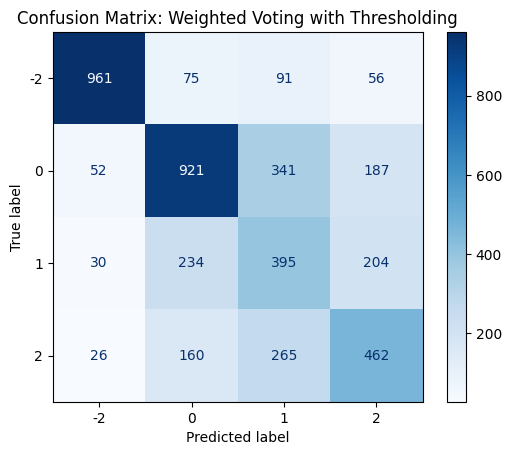

In [33]:
def filter_workers_by_accuracy(worker_accuracy, threshold=0.6):
    return {worker: acc for worker, acc in worker_accuracy.items() if acc >= threshold}

filtered_workers = filter_workers_by_accuracy(worker_accuracy, 0.6)

# Set a random seed for reproducibility
np.random.seed(42)

# Reuse weighted_majority_vote function, but limit to filtered workers
weighted_results = []
for (topicID, docID), group in grouped_tasks:
    weighted_label = weighted_majority_vote(group, filtered_workers)
    gold_label = group['gold'].iloc[0]
    weighted_results.append({'topicID': topicID, 'docID': docID, 'weighted_label': weighted_label, 'gold': gold_label})

results_df = pd.DataFrame(weighted_results)
accuracy = (results_df['weighted_label'] == results_df['gold']).mean()
print(f"Accuracy of Weighted Voting with Thresholding: {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(results_df['gold'], results_df['weighted_label'], labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: Weighted Voting with Thresholding")


## Experiment 4: Task-Specific Weighted Voting

**Objective**: This experiment accounts for task-specific worker performance. For example, a worker who performs well on highly relevant tasks (`2`) may not perform well on broken link tasks (`-2`).

**Key Steps**:
1. Compute worker accuracy separately for each gold label category (e.g., `2`, `1`, `0`, `-2`).
2. Use task-specific weights when aggregating labels for a task.
3. Perform weighted majority voting using these task-specific weights.

**Evaluation**: Accuracy and a confusion matrix are used as metrics.

**Expected Outcome**: Task-specific weights should improve accuracy, particularly for tasks where worker performance varies by category.


Accuracy of Task-Specific Weighted Voting: 80.07%


Text(0.5, 1.0, 'Confusion Matrix: Task-Specific Weighted Voting')

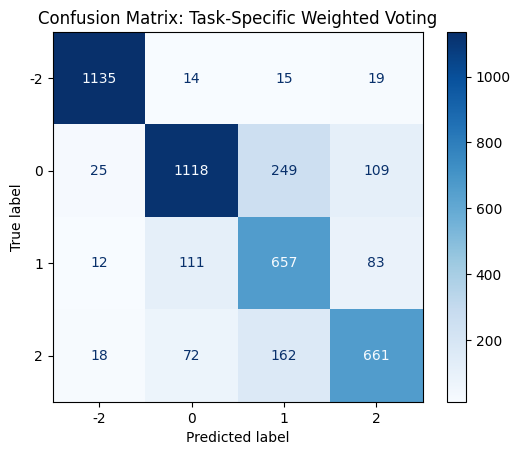

In [37]:
# Compute task-specific worker accuracy
def compute_task_specific_accuracy(gold_data):
    task_accuracies = defaultdict(lambda: defaultdict(list))
    for _, row in gold_data.iterrows():
        worker = row['workerID']
        gold_label = row['gold']
        is_correct = int(row['label'] == gold_label)
        task_accuracies[gold_label][worker].append(is_correct)
    
    worker_task_accuracy = defaultdict(lambda: defaultdict(float))
    for gold_label, workers in task_accuracies.items():
        for worker, correct_list in workers.items():
            worker_task_accuracy[gold_label][worker] = np.mean(correct_list)
    
    return worker_task_accuracy

worker_task_accuracy = compute_task_specific_accuracy(gold_data)

# Weighted majority vote using task-specific weights
def weighted_majority_vote_task_specific(group, worker_task_accuracy):
    weighted_votes = defaultdict(float)
    gold_label = group['gold'].iloc[0]  # For reference
    for _, row in group.iterrows():
        worker = row['workerID']
        label = row['label']
        weight = worker_task_accuracy[gold_label].get(worker, 0)
        weighted_votes[label] += weight
    max_weight = max(weighted_votes.values())
    top_labels = [label for label, weight in weighted_votes.items() if weight == max_weight]
    return np.random.choice(top_labels)

# Apply task-specific weighted voting
weighted_results = []
for (topicID, docID), group in grouped_tasks:
    weighted_label = weighted_majority_vote_task_specific(group, worker_task_accuracy)
    gold_label = group['gold'].iloc[0]
    weighted_results.append({'topicID': topicID, 'docID': docID, 'weighted_label': weighted_label, 'gold': gold_label})

results_df = pd.DataFrame(weighted_results)
accuracy = (results_df['weighted_label'] == results_df['gold']).mean()
print(f"Accuracy of Task-Specific Weighted Voting: {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(results_df['gold'], results_df['weighted_label'], labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: Task-Specific Weighted Voting")

## Experiment 5: Random Forest Classifier

**Objective**: Transitioning to machine learning methods, this experiment trains a Random Forest classifier using task-level features to predict the gold label.

**Key Steps**:
1. Engineer features such as:
   - Number of workers per task.
   - Mean and maximum worker accuracy for the task.
   - Worker experience (number of tasks completed).
   - Label counts for each class (`2`, `1`, `0`, `-2`).
2. Train a Random Forest classifier on an 80-20 train-test split of the data.
3. Evaluate the classifier on the test set.

**Evaluation**: Accuracy and a confusion matrix are used to assess performance.

**Expected Outcome**: The Random Forest should leverage task-level features to outperform weighted voting methods.


Training Random Forest Classifier...
Accuracy of ML-Based Aggregation (Random Forest): 83.40%


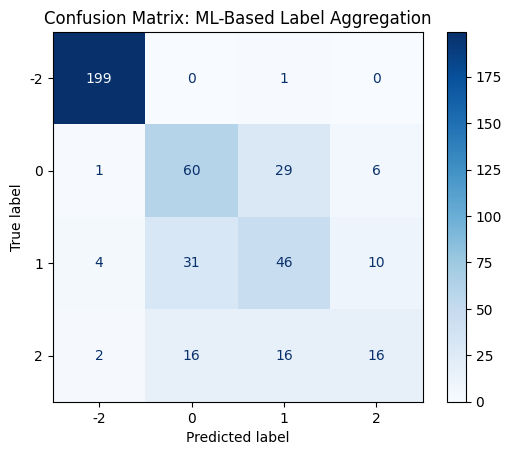

In [57]:

# Step 1: Feature Engineering
def compute_worker_accuracy(gold_data):
    """Compute worker accuracy based on gold-labeled tasks."""
    worker_accuracy = {}
    grouped = gold_data.groupby('workerID')
    for worker, group in grouped:
        correct = (group['label'] == group['gold']).sum()
        total = len(group)
        accuracy = correct / total if total > 0 else 0
        worker_accuracy[worker] = accuracy
    return worker_accuracy

# Filter only tasks with gold labels
gold_data = data[data['gold'] != -1]

# Compute worker accuracy
worker_accuracy = compute_worker_accuracy(gold_data)

# Add features to the dataset
data['worker_accuracy'] = data['workerID'].map(worker_accuracy)
data['worker_accuracy'].fillna(0.0, inplace=True)  # Default accuracy for unseen workers
data['worker_experience'] = data['workerID'].map(data['workerID'].value_counts())

# Group data by task to create aggregated features
grouped_tasks = data.groupby(['topicID', 'docID'])
task_features = []

for (topicID, docID), group in grouped_tasks:
    # Extract features for each task
    feature_row = {
        'topicID': topicID,
        'docID': docID,
        'num_workers': len(group),
        'mean_worker_accuracy': group['worker_accuracy'].mean(),
        'max_worker_accuracy': group['worker_accuracy'].max(),
        'worker_experience_mean': group['worker_experience'].mean(),
        'worker_experience_max': group['worker_experience'].max(),
        'label_0_count': (group['label'] == 0).sum(),
        'label_1_count': (group['label'] == 1).sum(),
        'label_2_count': (group['label'] == 2).sum(),
        'label_-2_count': (group['label'] == -2).sum(),
        'gold_label': group['gold'].iloc[0]  # True label (gold)
    }
    task_features.append(feature_row)

# Convert to DataFrame
task_features_df = pd.DataFrame(task_features)

# Step 2: Prepare Train-Test Data
X = task_features_df.drop(columns=['topicID', 'docID', 'gold_label'])  # Features
y = task_features_df['gold_label']  # Gold labels

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Machine Learning Model
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Make Predictions and Evaluate
y_pred = rf_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of ML-Based Aggregation (Random Forest): {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: ML-Based Label Aggregation")
disp.figure_.savefig("ml_label_aggregation_confusion_matrix.png")


## Experiment 6: XGBoost with Hyperparameter Tuning

**Objective**: Use XGBoost, a more sophisticated machine learning model, to further improve accuracy. Hyperparameter tuning is performed to optimize the model.

**Key Steps**:
1. Engineer the same task-level features as in Experiment 5.
2. Train an XGBoost classifier on an 80-20 train-test split.
3. Perform grid search cross-validation to find the best hyperparameters (e.g., learning rate, tree depth).
4. Evaluate the tuned model on the test set.

**Evaluation**: Accuracy and a confusion matrix are used.

**Expected Outcome**: XGBoost, with optimized hyperparameters, is expected to perform better than the Random Forest model.


Training XGBoost Classifier with Hyperparameter Tuning...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
Accuracy of ML-Based Aggregation (XGBoost): 85.84%


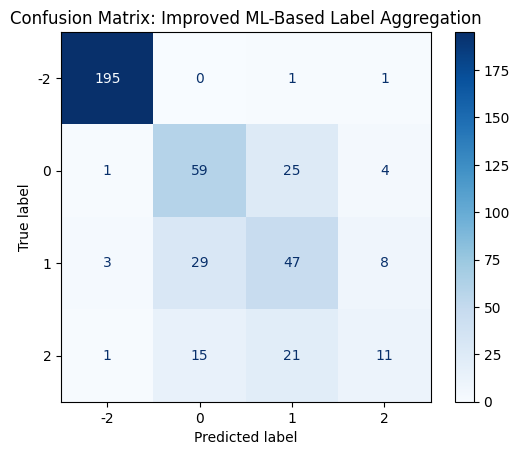

In [47]:
def compute_worker_accuracy(gold_data):
    """Compute worker accuracy based on gold-labeled tasks."""
    worker_accuracy = {}
    grouped = gold_data.groupby('workerID')
    for worker, group in grouped:
        correct = (group['label'] == group['gold']).sum()
        total = len(group)
        accuracy = correct / total if total > 0 else 0
        worker_accuracy[worker] = accuracy
    return worker_accuracy

# Filter only tasks with gold labels
gold_data = data[data['gold'] != -1]

# Compute worker accuracy
worker_accuracy = compute_worker_accuracy(gold_data)

# Add features to the dataset
data['worker_accuracy'] = data['workerID'].map(worker_accuracy)
data['worker_accuracy'].fillna(0.0, inplace=True)  # Default accuracy for unseen workers
data['worker_experience'] = data['workerID'].map(data['workerID'].value_counts())

# Group data by task to create aggregated features
grouped_tasks = data.groupby(['topicID', 'docID'])
task_features = []

for (topicID, docID), group in grouped_tasks:
    # Extract features for each task
    feature_row = {
        'topicID': topicID,
        'docID': docID,
        'num_workers': len(group),
        'mean_worker_accuracy': group['worker_accuracy'].mean(),
        'max_worker_accuracy': group['worker_accuracy'].max(),
        'worker_experience_mean': group['worker_experience'].mean(),
        'worker_experience_max': group['worker_experience'].max(),
        'label_0_count': (group['label'] == 0).sum(),
        'label_1_count': (group['label'] == 1).sum(),
        'label_2_count': (group['label'] == 2).sum(),
        'label_-2_count': (group['label'] == -2).sum(),
        'label_entropy': -sum((group['label'].value_counts(normalize=True) * 
                               np.log2(group['label'].value_counts(normalize=True) + 1e-6))),
        'gold_label': group['gold'].iloc[0]  # True label (gold)
    }
    task_features.append(feature_row)

# Convert to DataFrame
task_features_df = pd.DataFrame(task_features)
# Step 2: Map labels to positive integers
label_mapping = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}  # Map labels
inverse_label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping for evaluation

# Apply label mapping
task_features_df['gold_label'] = task_features_df['gold_label'].map(label_mapping)

# Prepare Train-Test Data
X = task_features_df.drop(columns=['topicID', 'docID', 'gold_label'])  # Features
y = task_features_df['gold_label']  # Mapped gold labels

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train XGBoost Classifier with Hyperparameter Tuning
print("Training XGBoost Classifier with Hyperparameter Tuning...")

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.7, 1.0]
}

xgb = XGBClassifier(random_state=42)
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_xgb = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# Step 4: Make Predictions and Convert Back to Original Labels
y_pred = best_xgb.predict(X_test)
y_test_original = [inverse_label_mapping[label] for label in y_test]
y_pred_original = [inverse_label_mapping[label] for label in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test_original, y_pred_original)
print(f"Accuracy of ML-Based Aggregation (XGBoost): {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred_original, labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: Improved ML-Based Label Aggregation")
disp.figure_.savefig("improved_ml_label_aggregation_confusion_matrix.png")


## Experiment 7: XGBoost with Class Weights

**Objective**: Address class imbalance by incorporating class weights into the XGBoost model.

**Key Steps**:
1. Calculate class weights based on the frequency of each gold label.
2. Train an XGBoost classifier with these weights applied.
3. Evaluate the model on the test set.

**Evaluation**: Accuracy and a confusion matrix are used to assess the impact of class weights.

**Expected Outcome**: Incorporating class weights should improve performance, especially for underrepresented classes.


Class Weights: {0: 3.4204564666103128, 1: 0.25655592188688814, 2: 2.695802798134577, 3: 4.688760139049826, 4: 4.431982475355969}
Training XGBoost Classifier with Class Weights...


/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:51:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBoost with Class Weights: 85.96%


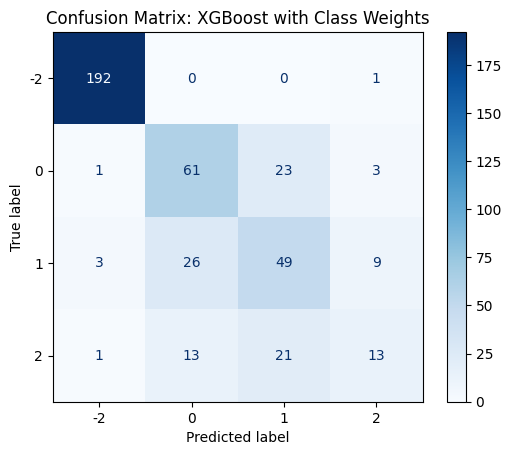

In [51]:
def compute_worker_accuracy(gold_data):
    """Compute worker accuracy based on gold-labeled tasks."""
    worker_accuracy = {}
    grouped = gold_data.groupby('workerID')
    for worker, group in grouped:
        correct = (group['label'] == group['gold']).sum()
        total = len(group)
        accuracy = correct / total if total > 0 else 0
        worker_accuracy[worker] = accuracy
    return worker_accuracy

# Filter only tasks with gold labels
gold_data = data[data['gold'] != -1]

# Compute worker accuracy
worker_accuracy = compute_worker_accuracy(gold_data)

# Add features to the dataset
data['worker_accuracy'] = data['workerID'].map(worker_accuracy)
data['worker_accuracy'].fillna(0.0, inplace=True)  # Default accuracy for unseen workers
data['worker_experience'] = data['workerID'].map(data['workerID'].value_counts())

# Group data by task to create aggregated features
grouped_tasks = data.groupby(['topicID', 'docID'])
task_features = []

for (topicID, docID), group in grouped_tasks:
    feature_row = {
        'topicID': topicID,
        'docID': docID,
        'num_workers': len(group),
        'mean_worker_accuracy': group['worker_accuracy'].mean(),
        'max_worker_accuracy': group['worker_accuracy'].max(),
        'worker_experience_mean': group['worker_experience'].mean(),
        'worker_experience_max': group['worker_experience'].max(),
        'label_0_count': (group['label'] == 0).sum(),
        'label_1_count': (group['label'] == 1).sum(),
        'label_2_count': (group['label'] == 2).sum(),
        'label_-2_count': (group['label'] == -2).sum(),
        'gold_label': group['gold'].iloc[0]  # True label (gold)
    }
    task_features.append(feature_row)

# Convert to DataFrame
task_features_df = pd.DataFrame(task_features)

# Step 2: Map labels to positive integers
label_mapping = {-2: 0, -1: 1, 0: 2, 1: 3, 2: 4}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}
task_features_df['gold_label'] = task_features_df['gold_label'].map(label_mapping)

# Prepare Train-Test Data
X = task_features_df.drop(columns=['topicID', 'docID', 'gold_label'])
y = task_features_df['gold_label']

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Calculate Class Weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"Class Weights: {class_weights_dict}")

# Step 4: Train XGBoost with Class Weights
print("Training XGBoost Classifier with Class Weights...")
xgb = XGBClassifier(n_estimators=200, max_depth=7, learning_rate=0.01, 
                    colsample_bytree=0.7, random_state=42, scale_pos_weight=class_weights_dict)

xgb.fit(X_train, y_train)

# Step 5: Make Predictions and Convert Back to Original Labels
y_pred = xgb.predict(X_test)
y_test_original = [inverse_label_mapping[label] for label in y_test]
y_pred_original = [inverse_label_mapping[label] for label in y_pred]

# Calculate accuracy
accuracy = accuracy_score(y_test_original, y_pred_original)
print(f"Accuracy of XGBoost with Class Weights: {accuracy:.2%}")

# Confusion Matrix
cm = confusion_matrix(y_test_original, y_pred_original, labels=[-2, 0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[-2, 0, 1, 2])
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix: XGBoost with Class Weights")
disp.figure_.savefig("xgboost_class_weights_confusion_matrix.png")
